# Problem Statement

[Urban Sound Classification](https://datahack.analyticsvidhya.com/contest/practice-problem-urban-sound-classification/): Classify Urban Sound Clips into different classes. This notebook is based on [https://www.analyticsvidhya.com/blog/2017/08/audio-voice-processing-deep-learning/#comment-143974]

The dataset contains 8732 sound excerpts (<=4s) of urban sounds from 10 classes, namely:

- air conditioner
- car horn
- children playing
- dog bark
- drilling
- engine idling
- gun shot
- jackhammer
- siren
- street music

In [1]:
import os

import numpy as np
import pandas as pd

import librosa
import librosa.display

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# to make this notebook's output stable across runs
np.random.seed(42)
random_state = 42

In [3]:
data_dir = "C:/urban-sound-challenge/"

## Prepare Data for Machine Learning: Load audio files and extract features

We already prepared the data in our urban-sound-classification-exploration notebook.

In [4]:
train_df = pd.read_csv(os.path.join(data_dir, "train_df.csv"))
valid_df = pd.read_csv(os.path.join(data_dir, "valid_df.csv"))
test_df = pd.read_csv(os.path.join(data_dir, "test_df.csv"))

In [5]:
train_df.head(5)

,ID,File_Name,Class
0,6020,C:/urban-sound-challenge/train/6020.wav,engine_idling
1,3940,C:/urban-sound-challenge/train/3940.wav,drilling
2,7614,C:/urban-sound-challenge/train/7614.wav,car_horn
3,3154,C:/urban-sound-challenge/train/3154.wav,jackhammer
4,2835,C:/urban-sound-challenge/train/2835.wav,siren


In [6]:
valid_df.head(5)

,ID,File_Name,Class
0,2179,C:/urban-sound-challenge/train/2179.wav,drilling
1,7030,C:/urban-sound-challenge/train/7030.wav,street_music
2,884,C:/urban-sound-challenge/train/884.wav,car_horn
3,4011,C:/urban-sound-challenge/train/4011.wav,dog_bark
4,586,C:/urban-sound-challenge/train/586.wav,engine_idling


In [7]:
test_df.head(5)

,ID,File_Name
0,8204,C:/urban-sound-challenge/test/8204.wav
1,8362,C:/urban-sound-challenge/test/8362.wav
2,5111,C:/urban-sound-challenge/test/5111.wav
3,5156,C:/urban-sound-challenge/test/5156.wav
4,6299,C:/urban-sound-challenge/test/6299.wav


In [8]:
# function to load files and extract features
def mfcc_feature_extractor(row):
    # handle exception to check if there isn't a file which is corrupted
    try:
        # here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(row.File_Name, res_type='kaiser_fast') 
        # we extract mfcc feature from data
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=80).T,axis=0)
        # we extract the tempo and beat frames
        tempo, beat_frames = librosa.beat.beat_track(y=X, sr=sample_rate)
    except Exception as e:
        print("Error encountered while parsing file: ", row.File_Name)
        return None
 
    feature = np.hstack([mfccs, tempo])
 
    return [feature]

In [9]:
# function to load files and extract features
def mel_feature_extractor(row):
    # handle exception to check if there isn't a file which is corrupted
    try:
        # here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(row.File_Name, res_type='kaiser_fast') 
        # we extract mel feature from data
        mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    except Exception as e:
        print("Error encountered while parsing file: ", row.file_name)
        return None
 
    feature = np.hstack([mel])
 
    return [feature]

In [10]:
# function to load files and extract features
def chroma_feature_extractor(row):
    # handle exception to check if there isn't a file which is corrupted
    try:
        # here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(row.File_Name, res_type='kaiser_fast') 
        # we extract chroma feature from data
        stft = np.abs(librosa.stft(X))
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    except Exception as e:
        print("Error encountered while parsing file: ", row.File_Name)
        return None
 
    feature = np.hstack([chroma])
 
    return [feature]

In [11]:
# function to load files and extract features
def tonnetz_feature_extractor(row):
    # handle exception to check if there isn't a file which is corrupted
    try:
        # here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(row.File_Name, res_type='kaiser_fast') 
        # we extract tonnetz feature from data
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    except Exception as e:
        print("Error encountered while parsing file: ", row.File_Name)
        return None
 
    feature = np.hstack([tonnetz])
 
    return [feature]

In [12]:
# function to load files and extract features
def contrast_feature_extractor(row):
    # handle exception to check if there isn't a file which is corrupted
    try:
        # here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(row.File_Name, res_type='kaiser_fast') 
        # we extract contrast feature from data
        stft = np.abs(librosa.stft(X))
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    except Exception as e:
        print("Error encountered while parsing file: ", row.File_Name)
        return None
 
    feature = np.hstack([contrast])
 
    return [feature]

Encode all categorical class labels into integer values. We will need this later for one-hot encoding of labels for Neural Network to work.

In [13]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
lb.fit(train_df['Class'])

LabelEncoder()

In [14]:
lb.classes_

array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music'], dtype=object)

In [15]:
# choose an extractor function
feature_extractor_func, feature_extractor_code = mfcc_feature_extractor, 'mfcc802L'
#feature_extractor_func, feature_extractor_code = mel_feature_extractor, 'mel'
#feature_extractor_func, feature_extractor_code = chroma_feature_extractor, 'chroma'
#feature_extractor_func, feature_extractor_code = tonnetz_feature_extractor, 'tonnetz'
#feature_extractor_func, feature_extractor_code = contrast_feature_extractor, 'contrast'

In [16]:
train_feature_df = pd.DataFrame({'feature':train_df.apply(feature_extractor_func, axis=1), 'label': train_df['Class']})

In [17]:
valid_feature_df = pd.DataFrame({'feature':valid_df.apply(feature_extractor_func, axis=1), 'label': valid_df['Class']})

In [18]:
test_feature_df = pd.DataFrame({'feature':test_df.apply(feature_extractor_func, axis=1)})

In [19]:
from keras.utils import np_utils

X_train, X_valid = np.array(train_feature_df.feature.tolist()), np.array(valid_feature_df.feature.tolist())
X_test = np.array(test_feature_df.feature.tolist())

y_train, y_valid = np.array(train_feature_df.label.tolist()), np.array(valid_feature_df.label.tolist())

# one-hot-encoded labels for neural network
y_train, y_valid = np_utils.to_categorical(lb.transform(y_train)), np_utils.to_categorical(lb.transform(y_valid))

Using TensorFlow backend.


In [20]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape

((4076, 1, 81), (4076, 10), (1359, 1, 81), (1359, 10), (3297, 1, 81))

In [21]:
X_train = np.squeeze(X_train, axis=1)
X_valid = np.squeeze(X_valid, axis=1)
X_test = np.squeeze(X_test, axis=1)

In [22]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape

((4076, 81), (4076, 10), (1359, 81), (1359, 10), (3297, 81))

In [23]:
X_train

array([[ -4.18145830e+02,   1.41875011e+02,  -2.59453264e+01, ...,
         -2.51678994e-01,  -8.25737999e-01,   9.93840144e+01],
       [ -1.34151356e+02,   1.66165834e-01,  -7.10923434e+01, ...,
          1.25476778e+00,   1.85749645e-01,   1.07666016e+02],
       [ -1.12576858e+02,   8.27931670e+01,  -1.98774221e+01, ...,
         -1.48478439e+00,   9.91034486e-02,   1.43554688e+02],
       ..., 
       [ -9.90368274e+01,   1.48076138e+02,  -1.37873875e+01, ...,
         -5.82632840e-01,  -3.47071287e-01,   1.43554688e+02],
       [ -4.19864877e+02,   1.92172040e+02,  -1.59026642e+01, ...,
         -4.60643792e-01,  -5.07748745e-01,   1.84570312e+02],
       [ -2.62055924e+02,   1.36037157e+02,  -1.51834820e+01, ...,
         -1.67984484e+00,  -1.12165886e+00,   1.03359375e+02]])

In [24]:
y_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

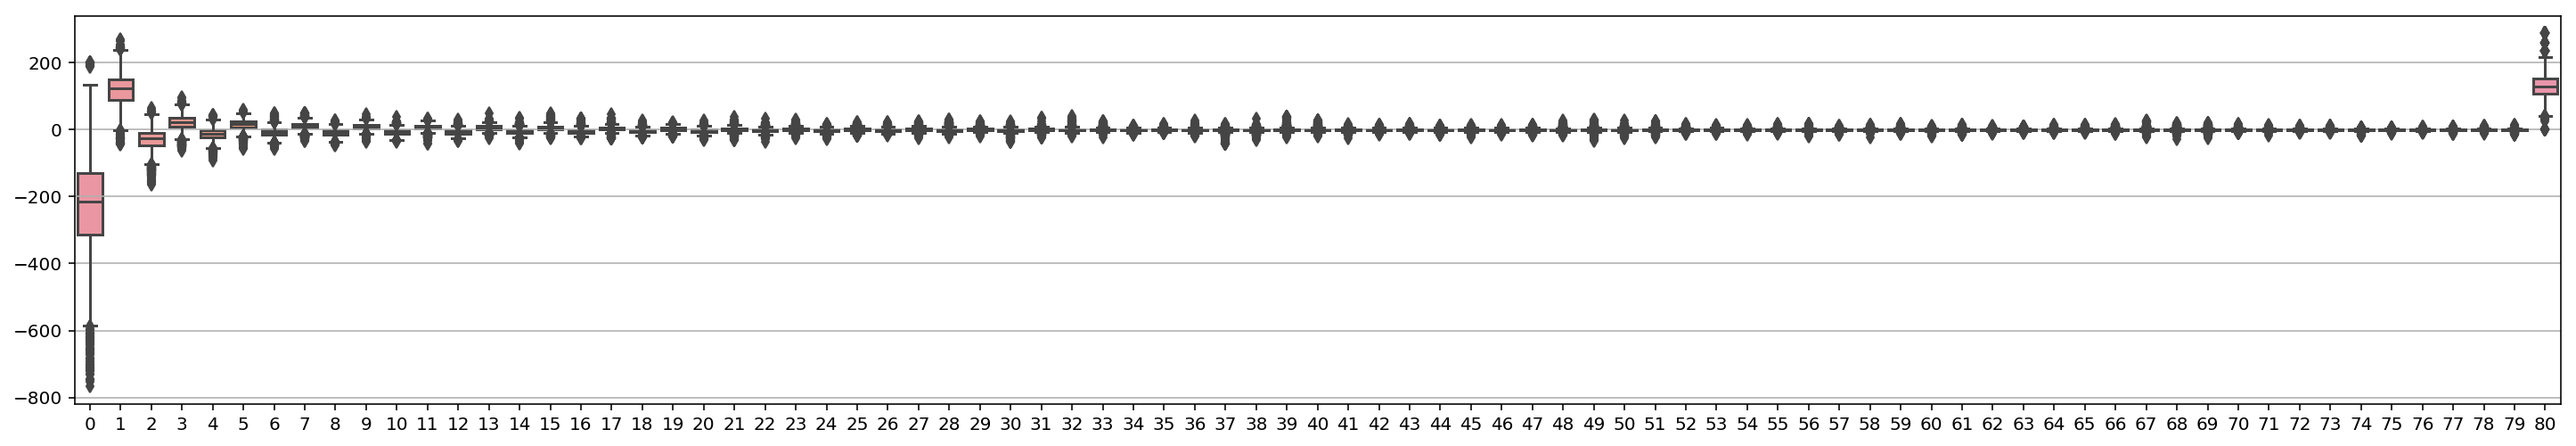

In [25]:
plt.figure(figsize=(25, 4))
plt.grid(which='major')
sns.boxplot(data=pd.DataFrame(X_train));

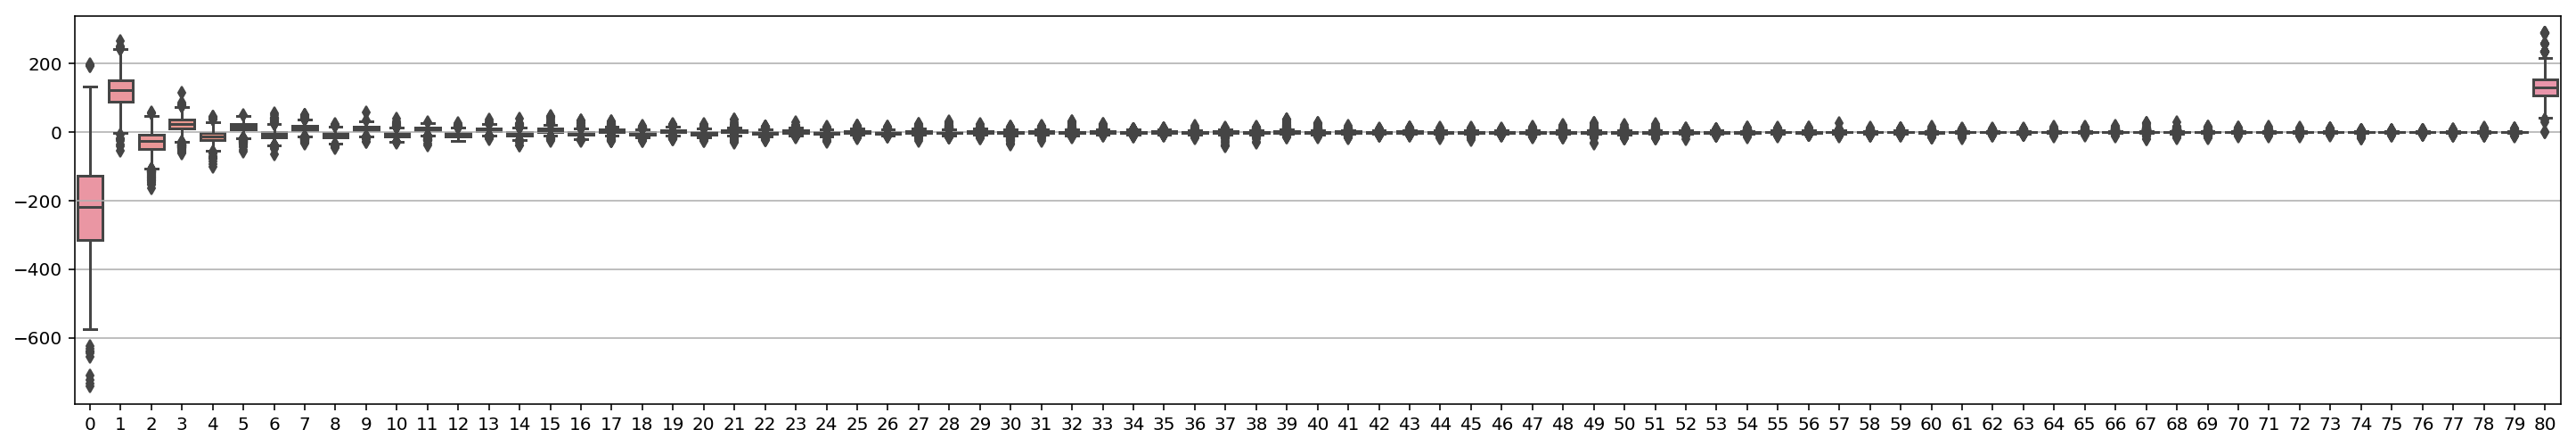

In [26]:
plt.figure(figsize=(25, 4))
plt.grid(which='major')
sns.boxplot(data=pd.DataFrame(X_valid));

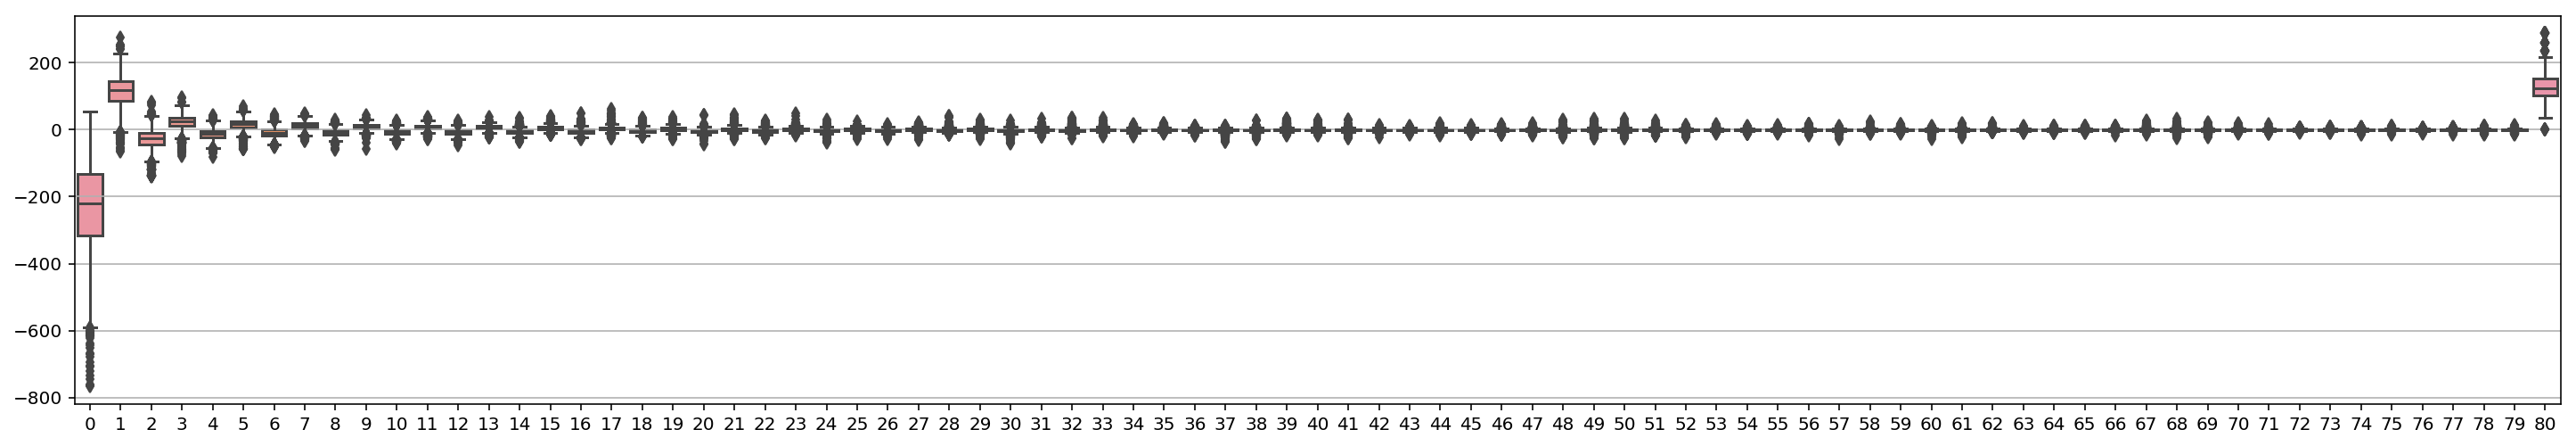

In [27]:
plt.figure(figsize=(25, 4))
plt.grid(which='major')
sns.boxplot(data=pd.DataFrame(X_test));

## Train a Neural Network Model

In [28]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

from sklearn import metrics 

In [29]:
feature_size = X_train.shape[1]
num_classes = y_train.shape[1]

batch_size = 32
epochs = 50

In [30]:
# a simple neural network
def mlp():
    model = Sequential()

    model.add(Dense(256, input_shape=(feature_size,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    return model

In [31]:
model = mlp()

In [32]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               20992     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
__________

In [34]:
earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
tbCallBack = TensorBoard(log_dir='./urban.sound.tb.graph', histogram_freq=0, write_graph=True, write_images=True)

In [35]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                            validation_data=(X_valid, y_valid), verbose=2).history

Train on 4076 samples, validate on 1359 samples
Epoch 1/50
 - 0s - loss: 12.6168 - acc: 0.1690 - val_loss: 10.8758 - val_acc: 0.2701
Epoch 2/50
 - 0s - loss: 11.0142 - acc: 0.2608 - val_loss: 9.7473 - val_acc: 0.3282
Epoch 3/50
 - 0s - loss: 9.2559 - acc: 0.2981 - val_loss: 4.0757 - val_acc: 0.4459
Epoch 4/50
 - 0s - loss: 4.0288 - acc: 0.3660 - val_loss: 1.6343 - val_acc: 0.5313
Epoch 5/50
 - 0s - loss: 2.1330 - acc: 0.3876 - val_loss: 1.5518 - val_acc: 0.5533
Epoch 6/50
 - 0s - loss: 1.7599 - acc: 0.4367 - val_loss: 1.4213 - val_acc: 0.6159
Epoch 7/50
 - 0s - loss: 1.5940 - acc: 0.4828 - val_loss: 1.2922 - val_acc: 0.6578
Epoch 8/50
 - 0s - loss: 1.4311 - acc: 0.5292 - val_loss: 1.2081 - val_acc: 0.6836
Epoch 9/50
 - 0s - loss: 1.3893 - acc: 0.5402 - val_loss: 1.1114 - val_acc: 0.6939
Epoch 10/50
 - 0s - loss: 1.2833 - acc: 0.5770 - val_loss: 1.0362 - val_acc: 0.7241
Epoch 11/50
 - 0s - loss: 1.2006 - acc: 0.5962 - val_loss: 0.9785 - val_acc: 0.7366
Epoch 12/50
 - 0s - loss: 1.1509 -

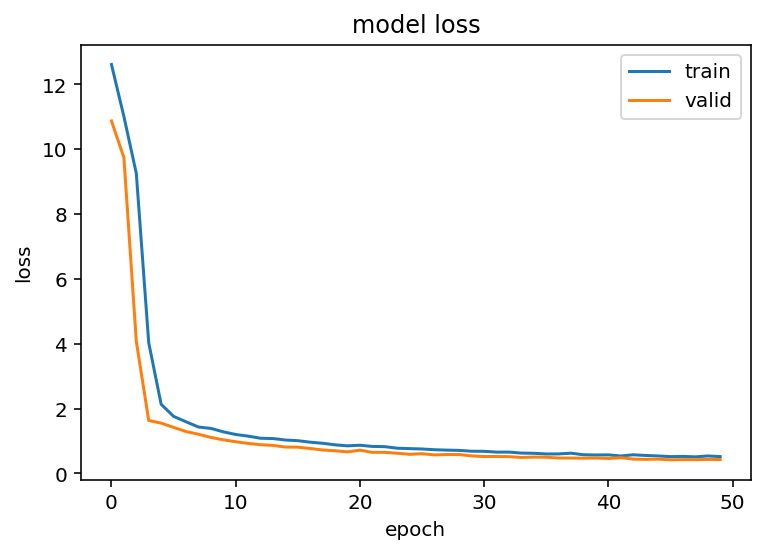

In [36]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')
plt.show()

In [37]:
# predict on our test set
y_test_pred = model.predict(X_test)
y_test_pred

array([[  3.32240939e-01,   4.80955690e-02,   6.34895787e-02, ...,
          1.44392118e-01,   1.13131218e-02,   2.15691611e-01],
       [  1.41572700e-05,   1.95146313e-05,   7.28875119e-03, ...,
          5.06204742e-07,   9.22409713e-01,   1.34241942e-03],
       [  1.33584172e-01,   6.78379741e-03,   3.12083185e-01, ...,
          1.54277412e-04,   1.69026703e-01,   7.69600794e-02],
       ..., 
       [  1.75512265e-04,   5.66252647e-03,   1.40439940e-03, ...,
          7.91082263e-01,   6.57554920e-05,   6.97009265e-04],
       [  3.72527836e-17,   1.13581204e-17,   4.83979801e-11, ...,
          3.94960088e-22,   9.99983788e-01,   4.52200694e-15],
       [  4.98468466e-02,   3.04858554e-02,   1.01363577e-01, ...,
          3.87102086e-03,   6.20806515e-02,   3.59089404e-01]], dtype=float32)

In [38]:
# predict on our validation set
y_valid_pred = model.predict(X_valid)

### Get the actual class name of prediction

In [39]:
# the classes encoded by the sklearn's LabelEncoder
lb.classes_

array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music'], dtype=object)

In [40]:
# get the actual class name of the prediction
lb.classes_[np.argmax(y_test_pred[9])] # for a random data point

'engine_idling'

Numpy's apply_along_axis is a very hanndy function that applies a function to 1-D slices along the given axis. We can use that to extract out the index where the predicted probability is maximum and then use that index to get the class name from the LabelEncoder.

In [41]:
np.apply_along_axis(func1d=np.argmax, axis=1, arr=y_test_pred)

array([0, 8, 2, ..., 7, 8, 9], dtype=int64)

In [42]:
y_test_pred_class = pd.Series(map(lambda x: lb.classes_[x], np.apply_along_axis(np.argmax, 1, y_test_pred)))
y_test_pred_class.head(5)

0     air_conditioner
1               siren
2    children_playing
3       engine_idling
4       engine_idling
dtype: object

In [43]:
y_valid_pred_class = pd.Series(map(lambda x: lb.classes_[x], np.apply_along_axis(np.argmax, 1, y_valid_pred)))
y_test_pred_class.head(5)

0     air_conditioner
1               siren
2    children_playing
3       engine_idling
4       engine_idling
dtype: object

## Explore Sounds where the Model was Incorrect

In [44]:
y_valid_true_class = pd.Series(map(lambda x: lb.classes_[x], np.apply_along_axis(np.argmax, 1, y_valid)))

In [45]:
def evaluate_random_file(idx, df, y_pred, y_true=None):
    file_name = df.iloc[idx]['File_Name']
    print('File: ', file_name)
    print('Predictions:', y_pred[idx])
    print('Predicted Class: ', lb.classes_[np.argmax(y_pred[idx])])
    if y_true is not None:
        print('Actual Class: ', lb.classes_[np.argmax(y_true[idx])])
    data, sampling_rate = librosa.load(file_name)
    plt.figure(figsize=(12, 4))
    librosa.display.waveplot(data, sr=sampling_rate)
    return file_name

File:  C:/urban-sound-challenge/train/4249.wav
Predictions: [  4.81358618e-01   6.59523823e-04   2.05180012e-02   3.67934955e-03
   6.13894314e-04   3.96113634e-01   6.52901799e-05   5.98574756e-04
   1.81403232e-03   9.45791230e-02]
Predicted Class:  air_conditioner
Actual Class:  engine_idling


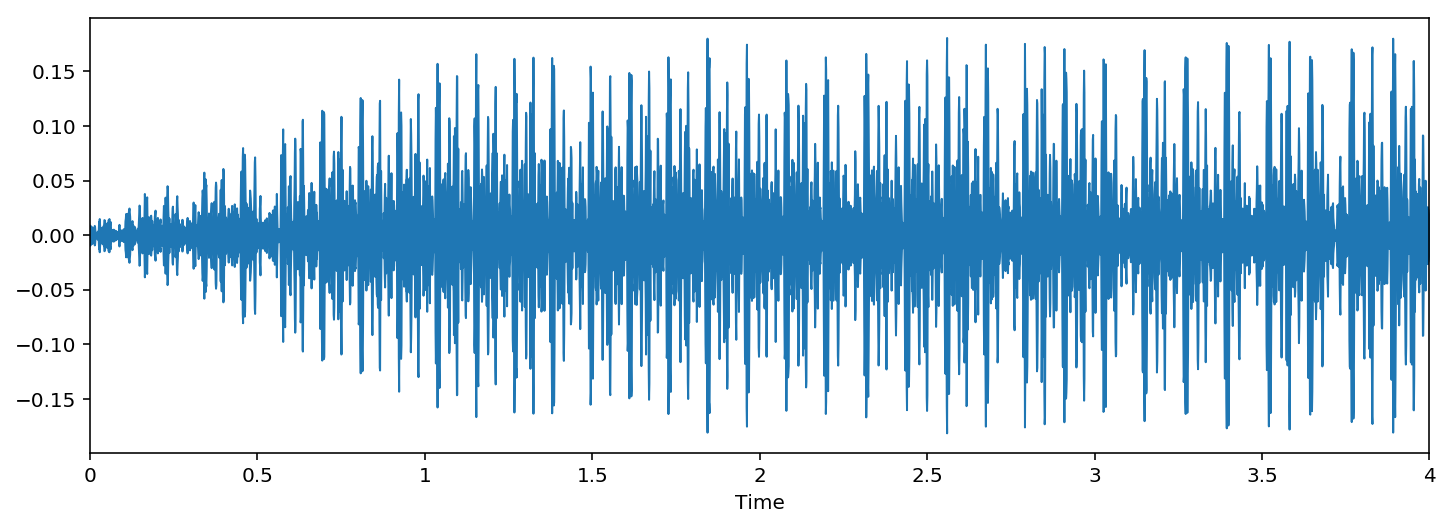

In [46]:
# Check a random sample where the prediction was wrong
idx = np.random.choice(np.where(y_valid_true_class != y_valid_pred_class)[0])
random_error_file = evaluate_random_file(idx, valid_df, y_valid_pred, y_valid)

In [47]:
import IPython.display as ipd
ipd.Audio(random_error_file)

File:  C:/urban-sound-challenge/train/408.wav
Predictions: [  2.57541146e-03   1.15363235e-02   6.15439594e-01   1.19960338e-01
   5.63972369e-02   7.54018500e-02   6.76668249e-03   1.00936639e-04
   1.86488386e-02   9.31725875e-02]
Predicted Class:  children_playing


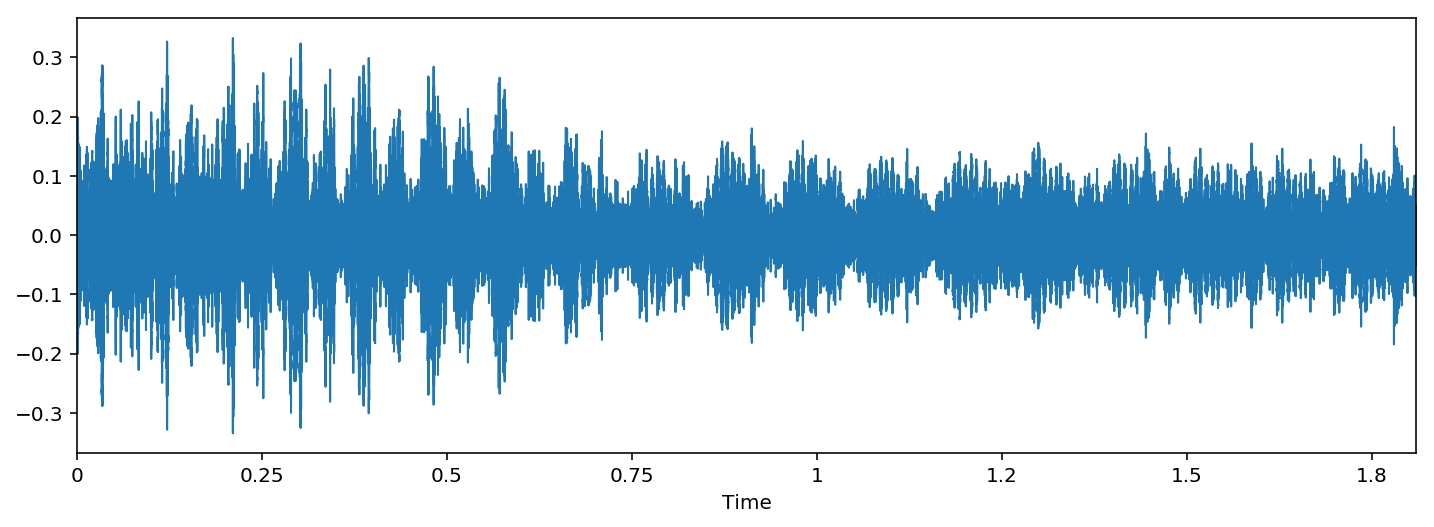

In [48]:
# One more
idx = np.random.choice(np.where(y_valid_true_class != y_valid_pred_class)[0])
random_error_file = evaluate_random_file(idx, valid_df, y_valid_pred)

In [49]:
import IPython.display as ipd
ipd.Audio(random_error_file)

## Evaluate on a random Test Data

File:  C:/urban-sound-challenge/test/1545.wav
Predictions: [  5.59124730e-23   3.81031532e-06   3.31886428e-12   2.58663613e-02
   9.74129617e-01   6.10145337e-11   1.71149102e-11   7.32898053e-15
   4.09496829e-12   2.55912397e-07]
Predicted Class:  drilling


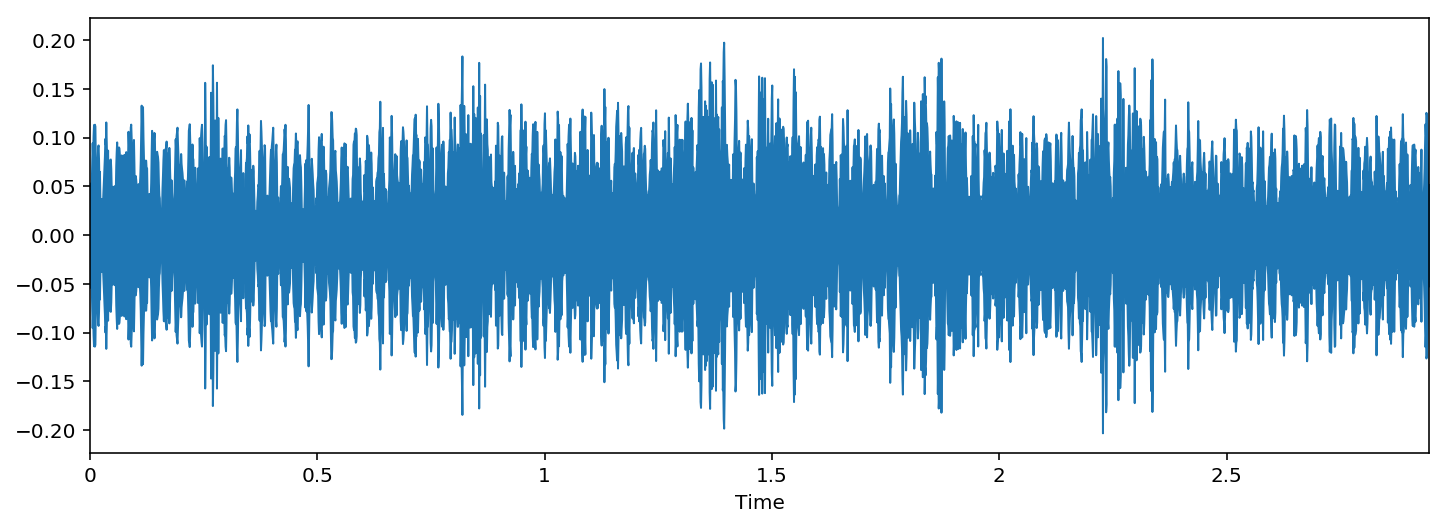

In [50]:
idx = np.random.choice(test_df.index)
test_file = evaluate_random_file(idx, test_df, y_test_pred)

In [51]:
import IPython.display as ipd
ipd.Audio(test_file)

## Create Submission

In [52]:
submit_df = pd.DataFrame({'Class': y_test_pred_class, 'ID':test_df.ID})
submit_df.columns = ['Class', 'ID']
submit_df.head(10)

,Class,ID
0,air_conditioner,8204
1,siren,8362
2,children_playing,5111
3,engine_idling,5156
4,engine_idling,6299
5,engine_idling,3594
6,children_playing,3912
7,drilling,701
8,street_music,592
9,engine_idling,8408


In [53]:
submit_df.to_csv(os.path.join(data_dir, "submission_{0}.csv".format(feature_extractor_code)), header=True, index=False)

In [54]:
# dump the prediction on the validation set
(pd.DataFrame({'pred_{0}'.format(feature_extractor_code): y_valid_pred_class})
 .to_csv(os.path.join(data_dir, "valid_pred_{0}.csv".format(feature_extractor_code)), header=True, index=False))